# Run missing models

## Import modules

In [2]:
import openml
import json
import collections
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.compose import make_column_transformer, ColumnTransformer
from matplotlib import pyplot as plt

# set api key
openml.config.apikey = open('.key', 'r').readline().strip('\n')

# get all supervised classification tasks 
tasks_all = openml.tasks.list_tasks(task_type_id=1, output_format='dataframe', tag = 'OpenML-CC18')

## Match Setups of Mixed Tasks

### Get evaluations

In [3]:
# get HGB evals
evals = openml.evaluations.list_evaluations('area_under_roc_curve', 
                                            uploader = [8323], 
                                            flow=[16374, 16347, 16345], 
                                            output_format='dataframe')

In [4]:
# get evals of mixed tasks
mixed_tasks = [23, 29, 31, 219, 2079, 3021, 3022, 7592, 9971, 9977, 14954, 14965, 125920, 167125, 167141]
evals_mixed = evals[evals.task_id.isin(mixed_tasks)]
evals_mixed.shape
len(evals_mixed.setup_id.unique())

3242

In [5]:
# get evals of pure tasks
ids = (evals.setup_id.value_counts()).index[(evals.setup_id.value_counts() >= 10)]
evals_pure = evals[evals.setup_id.isin(ids)]
evals_pure.shape
len(evals_pure.setup_id.unique())

327

### Get setups

In [6]:
# get setups of mixed tasks
setup_info_names = list(evals_mixed.columns)
param_names = ['C', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 
               'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 
               'shrinking', 'tol', 'verbose']

setups_mixed = pd.DataFrame(columns = setup_info_names+param_names)

for i in evals_mixed.iterrows():
    setup_model = openml.setups.initialize_model(i[1].setup_id)
    params = setup_model.steps[2][1].get_params().values()
    
    setups_mixed.loc[len(setups_mixed)] = list(i[1])+list(params)

In [7]:
# get setups of pure tasks
setup_info_names = ['setup_id']
param_names = list(openml.setups.initialize_model(8231383).steps[2][1].get_params().keys())

setups_pure = pd.DataFrame(columns = setup_info_names+param_names)

for i in evals_pure.setup_id.unique():
    setup_model = openml.setups.initialize_model(i)
    params = setup_model.steps[2][1].get_params().values()
    
    setups_pure.loc[len(setups_pure)] = [i]+list(params)


### Match and reassign setups to correct setup_ids

In [8]:
# match setup_ids
param_keys = ['C', 'coef0', 'degree', 'gamma', 'kernel', 'max_iter']
id_match = pd.DataFrame(columns= ['setup_id_mixed', 'setup_id'])

for i in range(len(setups_mixed)):
    print(i, end='\r')
    for j in range(len(setups_pure)):
        if all(setups_mixed.loc[i][param_keys] == setups_pure.loc[j][param_keys]): 
            id_match.loc[len(id_match)] = (setups_mixed.loc[i]['setup_id'], setups_pure.loc[j]['setup_id'])
        

In [9]:
# reassign setup_ids
evals_mixed_final = pd.DataFrame(columns = ['run_id', 'task_id', 'setup_id', 'flow_id', 'flow_name', 'data_id',
                       'data_name', 'function', 'upload_time', 'value', 'values',
                        'array_data'])

for i in id_match.iterrows():
    try:
        x = evals_mixed[evals_mixed.setup_id == i[1][0]]
        x.iat[0,2] = i[1][1]
        evals_mixed_final.loc[len(evals_mixed_final)] = list(x.values[0])
    except:
        print('', end ='')
    

### Recreate evaluation matrix with matched setups

In [10]:
# merge pure and mixed setups
evals = evals_pure.append(evals_mixed_final)

In [11]:
# drop runs with insufficient number of evals on CC-18
ids = (evals.setup_id.value_counts()).index[(evals.setup_id.value_counts() >= 5)]
evals_subset = evals[evals.setup_id.isin(ids)]

# transform to wide format
evals_wide = evals_subset.pivot_table(index = 'setup_id', 
                                      columns = 'task_id', 
                                      values = 'value')

evals_wide.shape

(327, 59)

## Identify indices of missing runs

In [12]:
# empty list for indices of missing values
missing = []

for i in evals_wide.columns:
    for j in evals_wide.index:
        
        coordinates = (j, i)
        
        value = evals_wide.at[coordinates]

        if np.isnan(value):
            missing.append(coordinates)
            
len(missing)

2829

In [13]:
missing = [k for k in missing if k[1] != 167124 and k[1] != 146825 and k[1] != 3573]
missing = [k for k in missing if k[0] != 6148258 and k[0] != 8231647]
len(missing)

2784

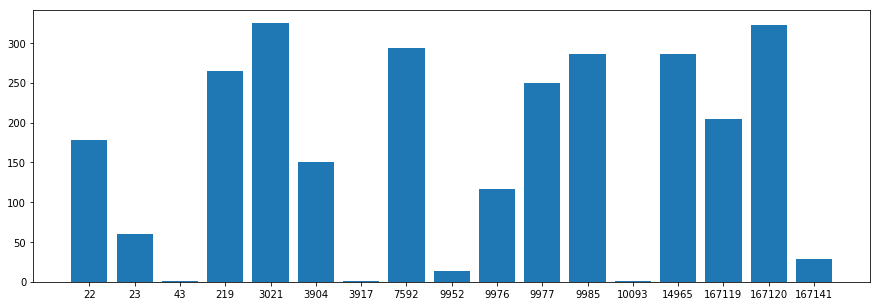

In [19]:
# count missing values for each task
data = collections.Counter([x[1] for x in missing]).values()
names = list(collections.Counter([x[1] for x in missing]).keys())

# create barplot
figure = plt.figure(figsize=(15,5))
plt.bar(x = range(len(data)), height = data, tick_label = names);

## Iterate through missing runs in random order

In [ ]:
random.shuffle(missing)

# loop over tasks
for i in missing.itertuples(index = False):
    try: 
        # get task   
        print('Load task', i[1])
        task = openml.tasks.get_task(i[1])
        
        # get dataset object 
        data = openml.datasets.get_dataset(task.dataset_id)

        # get relevant info from dataset object
        X, y, categorical_indicator, attribute_names = data.get_data(dataset_format='array',
                                                                    target=data.default_target_attribute)

        cat = categorical_indicator
        num = [not k for k in categorical_indicator]

        numeric_transformer = make_pipeline(#SimpleImputer(strategy='median'), 
                                            StandardScaler())

        categorical_transformer = make_pipeline(#SimpleImputer(strategy='most_frequent'),
                                                OneHotEncoder(handle_unknown='ignore'))

        preprocessor = ColumnTransformer(
        transformers=[
        ('num', numeric_transformer, num),
        ('cat', categorical_transformer, cat)])
        
        # initialize model with parameters from run
        print('Load model', i[0])
        
        if not any(categorical_indicator):
            pipe = openml.setups.initialize_model(i[0])
        elif all(categorical_indicator):
            pipe = openml.setups.initialize_model(i[0])
        else:
            svc_params = openml.setups.initialize_model(8231564).steps[2][1].get_params()
            clf = SVC(**svc_params)
            pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), preprocessor, clf)

        # run best model on the task
        print('Run model...')
        run = openml.runs.run_model_on_task(pipe, task)

        # print feedbackack
        print('Publish openml run...')
        print()

        # publish the run 
        run.publish()

    except Exception as e:
        print(e)
        continue
  

Load task 167119
Load model 8231614
Run model...
